In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 

In [1]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [2]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')
val_labels, val_data = read_data('../datasets/mc_dev_data.txt')


# new way, maybe the things after the words confused lambeq in creating the diagrams 
with open('../datasets/newTestSentences.txt', 'r') as file: 
    test_data = file.readlines()
with open('../datasets/newTrainSentences.txt', 'r') as file: 
    train_data = file.readlines()
with open('../datasets/newValSentences.txt', 'r') as file: 
    val_data = file.readlines()

test_data = [sentence.strip() for sentence in test_data]
train_data = [sentence.strip() for sentence in train_data]
val_data = [sentence.strip() for sentence in val_data]


In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


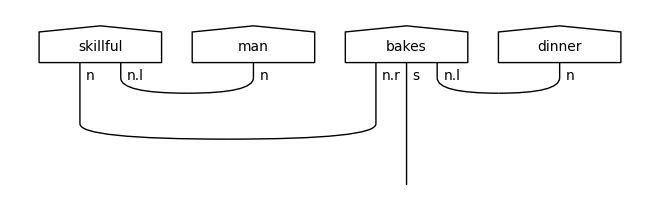

In [6]:
raw_train_diagrams[1].draw()

In [7]:
# train_diagrams = [
#     diagram.normal_form()
#     for diagram in raw_train_diagrams if diagram is not None
# ]
# val_diagrams = [
#     diagram.normal_form()
#     for diagram in raw_val_diagrams if diagram is not None
# ]

# train_labels = [
#     label for (diagram, label)
#     in zip(raw_train_diagrams, train_labels)
#     if diagram is not None]
# val_labels = [
#     label for (diagram, label)
#     in zip(raw_val_diagrams, val_labels)
#     if diagram is not None
# ]


# this is another way to normalise the diagrams 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



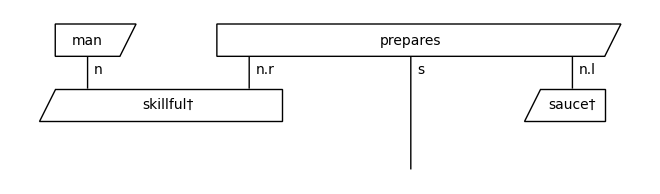

In [8]:
train_diagrams[0].draw()

In [9]:
# from lambeq.backend.tensor import Dim

# from lambeq import AtomicType, SpiderAnsatz

# # ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
# #                    n_layers=1, n_single_qubit_params=3)
# # remove_cups = RemoveCupsRewriter()

# # train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
# # val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]



# ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
#                        AtomicType.SENTENCE: Dim(2)})

# train_circuits = [ansatz(diagram) for diagram in train_diagrams]
# val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
# # test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# train_circuits[0].draw()

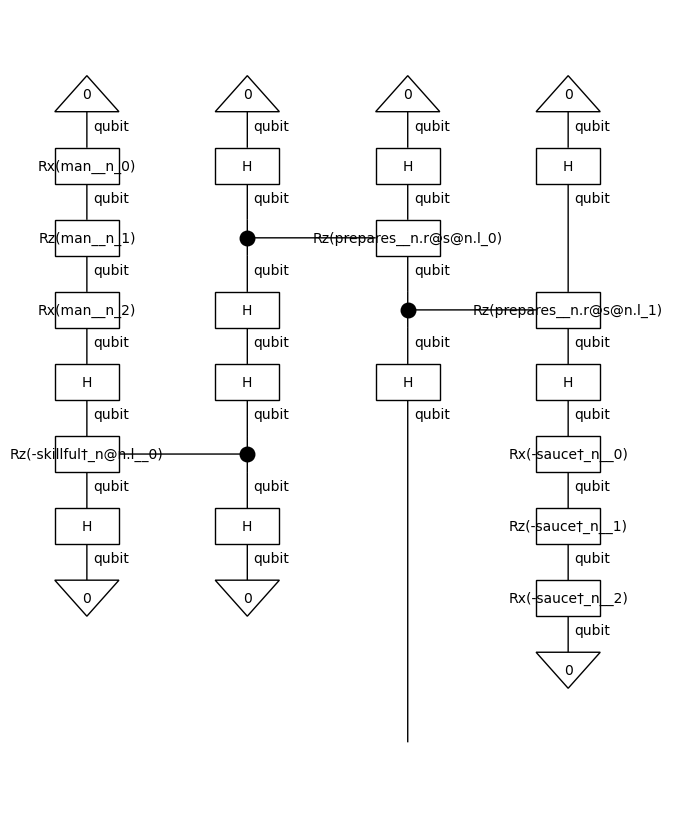

In [10]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [11]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



ModuleNotFoundError: No module named 'pennylane'

In [ ]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [ ]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [ ]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [ ]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.1281   valid/loss: 0.1693   train/acc: 0.7143   valid/acc: 0.7333
Epoch 2:    train/loss: 0.0313   valid/loss: 0.1128   train/acc: 0.8429   valid/acc: 0.7667
Epoch 3:    train/loss: 0.0575   valid/loss: 0.0816   train/acc: 0.9143   valid/acc: 0.8333
Epoch 4:    train/loss: 0.0634   valid/loss: 0.0515   train/acc: 0.9429   valid/acc: 0.9333
Epoch 5:    train/loss: 0.0148   valid/loss: 0.0441   train/acc: 0.9429   valid/acc: 0.9000
Epoch 6:    train/loss: 0.0042   valid/loss: 0.0540   train/acc: 0.9286   valid/acc: 0.9333
Epoch 7:    train/loss: 0.0303   valid/loss: 0.0567   train/acc: 0.9429   valid/acc: 0.9333
Epoch 8:    train/loss: 0.0011   valid/loss: 0.0621   train/acc: 0.9571   valid/acc: 0.9333
Epoch 9:    train/loss: 0.0348   valid/loss: 0.0657   train/acc: 0.9714   valid/acc: 0.9000
Epoch 10:   train/loss: 0.0361   valid/loss: 0.0672   train/acc: 0.9714   valid/acc: 0.9000
Epoch 11:   train/loss: 0.0100   valid/loss: 0.0669   train/acc: 0.9714   valid/

In [ ]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [ ]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.6846   valid/loss: 1.3163   train/acc: 0.5000   valid/acc: 0.4000
Epoch 2:    train/loss: 0.9006   valid/loss: 1.0370   train/acc: 0.6000   valid/acc: 0.5000
Epoch 3:    train/loss: 0.5037   valid/loss: 0.6249   train/acc: 0.6286   valid/acc: 0.5667
Epoch 4:    train/loss: 0.2982   valid/loss: 0.6238   train/acc: 0.7286   valid/acc: 0.6333
Epoch 5:    train/loss: 0.5654   valid/loss: 0.6068   train/acc: 0.6714   valid/acc: 0.6333
Epoch 6:    train/loss: 0.4729   valid/loss: 0.4664   train/acc: 0.7000   valid/acc: 0.7667
Epoch 7:    train/loss: 0.3551   valid/loss: 0.4809   train/acc: 0.7857   valid/acc: 0.8333
Epoch 8:    train/loss: 0.2770   valid/loss: 0.5096   train/acc: 0.8286   valid/acc: 0.8667
Epoch 9:    train/loss: 0.3540   valid/loss: 0.5123   train/acc: 0.8714   valid/acc: 0.8667
Epoch 10:   train/loss: 0.1754   valid/loss: 0.4528   train/acc: 0.8429   valid/acc: 0.8667
Epoch 11:   train/loss: 0.3335   valid/loss: 0.4068   train/acc: 0.9429   valid/

In [ ]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.5571   valid/loss: 1.4430   train/acc: 0.6071   valid/acc: 0.2667
Epoch 2:    train/loss: 1.2648   valid/loss: 1.7893   train/acc: 0.4857   valid/acc: 0.4333
Epoch 3:    train/loss: 0.6874   valid/loss: 1.5983   train/acc: 0.5857   valid/acc: 0.5667
Epoch 4:    train/loss: 0.5953   valid/loss: 0.9684   train/acc: 0.6286   valid/acc: 0.4333
Epoch 5:    train/loss: 0.6540   valid/loss: 1.5304   train/acc: 0.7571   valid/acc: 0.4667
Epoch 6:    train/loss: 0.6537   valid/loss: 1.3719   train/acc: 0.6643   valid/acc: 0.5500
Epoch 7:    train/loss: 0.3820   valid/loss: 0.6689   train/acc: 0.7214   valid/acc: 0.6000
Epoch 8:    train/loss: 0.9512   valid/loss: 1.9163   train/acc: 0.5357   valid/acc: 0.7333
Epoch 9:    train/loss: 1.1297   valid/loss: 1.6617   train/acc: 0.5000   valid/acc: 0.4833
Epoch 10:   train/loss: 0.4310   valid/loss: 1.5931   train/acc: 0.6286   valid/acc: 0.5667
Epoch 11:   train/loss: 0.7377   valid/loss: 0.8538   train/acc: 0.6857   valid/

In [ ]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelTK.symbols

# And the weights are their respective values 
weights = modelTK.weights

print('symbols: ', smbls)
print('weights: ', weights)

# now, we are only interested in the noun weights 

newSmbls = []
newWeights = []

verbSmbls = []
verbWeights = []

adjSmbls = []
adjWeights = []

for i in range(len(weights)): 
    if '__n_' in str(smbls[i]):# or '_N†_n__' in str(smbls[i]):
        newSmbls.append(smbls[i])
        newWeights.append(weights[i].item())
    elif 'TV' in str(smbls[i]): 
        verbSmbls.append(smbls[i])
        verbWeights.append(weights[i].item())
    elif 'ADJ' in str(smbls[i]): 
        adjSmbls.append(smbls[i])
        adjWeights.append(weights[i].item())


# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()

print(parameterDict)

wordsToForget = ['man', 'woman', 'person']

wordsToForget = ['dinner', 'meal', 'sauce', 'program', 'application', 'software']

print(parameterDict)

import pickle

with open('weightsDictTK.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)


print(newSmbls)
print(newWeights)


symbols:  [application__n_0, application__n_1, application__n_2, application†_n__0, application†_n__1, application†_n__2, bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, dinner__n_0, dinner__n_1, dinner__n_2, dinner†_n__0, dinner†_n__1, dinner†_n__2, man__n_0, man__n_1, man__n_2, man†_n__0, man†_n__1, man†_n__2, meal__n_0, meal__n_1, meal__n_2, meal†_n__0, meal†_n__1, meal†_n__2, person__n_0, person__n_1, person__n_2, person†_n__0, person†_n__1, person†_n__2, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, program__n_0, program__n_1, program__n_2, program†_n__0, program†_n__1, program†_n__2, reads__n.r@s@n.l_0, reads__n.r@s@n.l_1, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, sauce__n_0, sauce__n_1, sauce__n_2, sauce†_n__0, sauce†_n__1, sauce†_n__2, skillful†_n@n.l__0, software__n_0, software__n_1, software__n_2, software†_n__0, software†_n__1, software†_n__2, tasty†_n@n.l__0, useful†_n@n.l__0, woman__n_0, woman__n_1, woman__n_2, woman†_n__0, woman†_n__1, woman†_n

Symbol =  application__n_0
Statevector =  Statevector([0.       +0.j        , 0.0020208-0.99999796j],
            dims=(2,))
Symbol =  dinner__n_0
Statevector =  Statevector([ 0.        +0.j        , -0.24383483-0.96981677j],
            dims=(2,))
Symbol =  man__n_0
Statevector =  Statevector([ 0.99915547+0.04108957j, -0.        +0.j        ],
            dims=(2,))
Symbol =  meal__n_0
Statevector =  Statevector([0.99998613-0.00526728j, 0.        +0.j        ],
            dims=(2,))
Symbol =  person__n_0
Statevector =  Statevector([0.        +0.j        , 0.71433264-0.69980632j],
            dims=(2,))
Symbol =  program__n_0
Statevector =  Statevector([0.        +0.j        , 0.04814391-0.99884041j],
            dims=(2,))
Symbol =  sauce__n_0
Statevector =  Statevector([0.98891726-0.14846766j, 0.        -0.j        ],
            dims=(2,))
Symbol =  software__n_0
Statevector =  Statevector([0.88783705+0.46015798j, 0.        +0.j        ],
            dims=(2,))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Symbol =  woman__n_0
Statevector =  Statevector([0.99998227+0.00595527j, 0.        +0.j        ],
            dims=(2,))


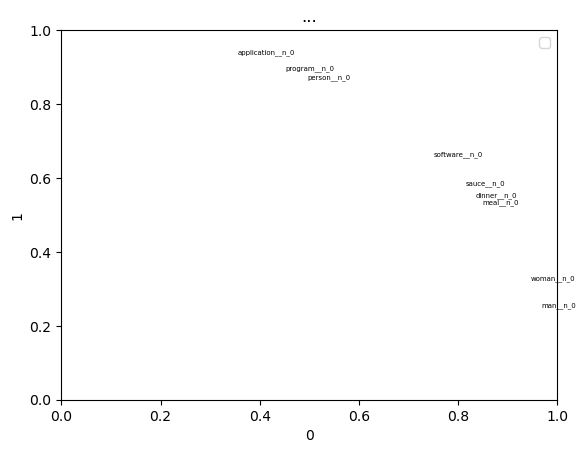

In [ ]:
'''
We want to see to what exact quantum states the respective nouns are mapped. We define a qiskit circuit consisting of a Rx, Rz, and Rx gate and we look at the quantum 
states that the respective nouns are mapped to. 
'''
# import matplotlib
from qiskit import QuantumCircuit, Aer, execute

def getProbDist(listOfParams): 
    '''
    Given a list of parameters, this function creates a circuit and returns the state and the probability distribution of said state
    '''

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1, 1)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)

    # Apply Rx and Rz gates
    qc.rx(listOfParams[0], 0)
    qc.rz(listOfParams[1], 0) 
    qc.rx(listOfParams[2], 0)

    # Measure the qubit
    qc.measure(0, 0)  # Measure qubit 0 and store the result in classical bit 0

    # Draw the circuit (optional)
    # print("Quantum Circuit:")
    # qc.draw(output='mpl', filename = 'testtesttest.png')

    # Use the Aer simulator to execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # statevectors simulator 
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=backend, shots = 1, memory = True)
    stateVector = job.result().get_statevector(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist, stateVector


NounsAndVecs = {}
nounStateList = []

# for plotting the Bloch spheres
from qiskit.visualization import plot_bloch_multivector

for i in range(0, len(newWeights), 3): 

    params = newWeights[i:i+3]

    # print(newSmbls[i:i+3])

    # print(params)

    probDist, nounState = getProbDist(params)

    nounStateList.append(nounState)

    # plot bloch sphere 
    print('Symbol = ', str(newSmbls[i]))
    print('Statevector = ', str(nounState))
    plot_bloch_multivector(nounState, title=str(newSmbls[i]), filename = 'blochMultivector' + str(i) + '.png')

    NounsAndVecs[str(newSmbls[i])] = probDist

    # plot in 2-dim cartesian system
    plt.text(np.sqrt(probDist['0']), np.sqrt(probDist['1']), str(newSmbls[i]), fontsize = 5)


plt.title('...')
plt.ylabel('1')
plt.xlabel('0')
plt.legend()
plt.show()
# print(NounsAndVecs)



In [ ]:
'''
We see that there is *no* system whatsoever. 
This might be due to the poor training as we can see in the plots below. 

I could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)

Later, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. 


NEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO 

'''

"\nWe see that there is *no* system whatsoever. \nThis might be due to the poor training as we can see in the plots below. \n\nI could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)\n\nLater, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. \n\n\nNEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO \n\n"

In [ ]:
def VerbCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(3)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)
    qc.initialize(initial_state, 2)

    qc.h(range(3))

    # add CNOT gates 
    qc.crz(paramList[0], 2, 1)
    qc.crz(paramList[1], 1, 0)

    qc.h(range(3))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='verbCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(VerbCircuit([1,2], draw= True))



     ┌─────────────────┐┌───┐         ┌───────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├─────────┤ Rz(2) ├┤ H ├
     ├─────────────────┤├───┤┌───────┐└───┬───┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├┤ Rz(1) ├────■────┤ H ├
     ├─────────────────┤├───┤└───┬───┘  ┌───┐  └───┘
q_2: ┤ Initialize(1,0) ├┤ H ├────■──────┤ H ├───────
     └─────────────────┘└───┘           └───┘       


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


{'000': 5.25780934030603e-06, '001': 1.66183287836071e-06, '010': 8.0643771242442e-07, '011': 1.66183287836071e-06, '100': 5.257933299646e-08, '101': 1.0835066732322e-07, '110': 3.4280652290523e-07, '111': 1.0835066732322e-07}


In [ ]:
'''
Now, the same thing for adjectives
'''

def AdjectivesCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(2)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)

    qc.h(range(2))

    # add CNOT gates 
    qc.crz(paramList[0], 1, 0)

    qc.h(range(2))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='adjCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(AdjectivesCircuit([3.14], draw= True))



     ┌─────────────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├┤ Rz(3.14) ├┤ H ├
     ├─────────────────┤├───┤└────┬─────┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├─────■──────┤ H ├
     └─────────────────┘└───┘            └───┘
{'00': 2.50398321889424e-06, '01': 2.49999841465942e-06, '10': 2.49601995178691e-06, '11': 2.49999841465942e-06}


Final test accuracy: 0.0


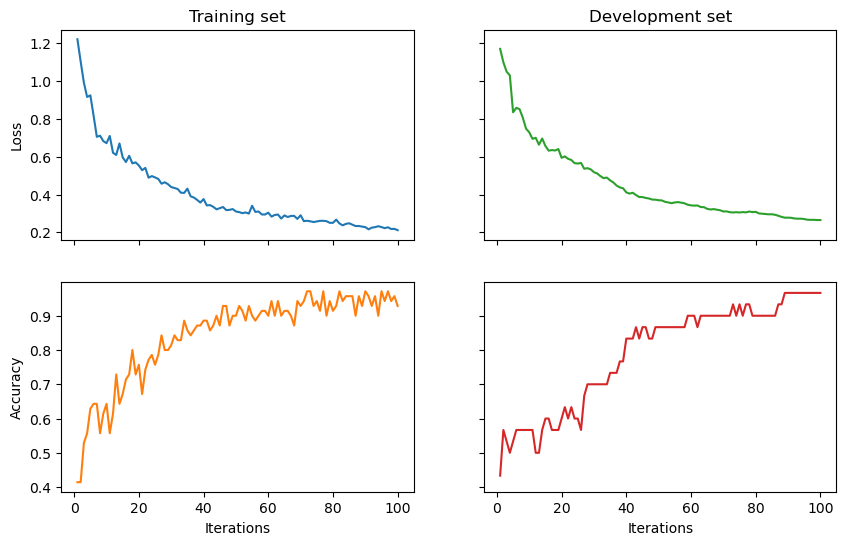

In [ ]:
import matplotlib.pyplot as plt

trainer = trainerNumpy
model = modelNumpy
acc = accNP
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [ ]:
'''
Now, for the density matrix part. 
We write a qiskit circuit and we predict, given the weights, the density matrices with the nouns missing
''' 
from qiskit import QuantumCircuit

a = modelNumpy.get_diagram_output(test_circuits)
print(len(a))

print(a)

# print(len(test_circuits))
# print(len(pred))

30
[[9.99859081e-01 1.40919299e-04]
 [9.63287454e-01 3.67125459e-02]
 [1.48993116e-01 8.51006884e-01]
 [8.21172338e-01 1.78827662e-01]
 [8.22945099e-01 1.77054901e-01]
 [3.36994265e-02 9.66300574e-01]
 [7.18308732e-02 9.28169127e-01]
 [2.83407853e-02 9.71659215e-01]
 [7.69991977e-01 2.30008023e-01]
 [9.07170065e-01 9.28299353e-02]
 [9.63077397e-01 3.69226033e-02]
 [1.46796839e-02 9.85320316e-01]
 [1.62391744e-01 8.37608256e-01]
 [9.27714610e-01 7.22853896e-02]
 [9.34842126e-01 6.51578739e-02]
 [4.14590529e-01 5.85409471e-01]
 [4.35200204e-01 5.64799796e-01]
 [1.14455778e-01 8.85544222e-01]
 [3.99011507e-01 6.00988493e-01]
 [5.56082171e-01 4.43917829e-01]
 [4.94610870e-01 5.05389130e-01]
 [7.31788202e-01 2.68211798e-01]
 [9.42738245e-01 5.72617551e-02]
 [8.35582080e-01 1.64417920e-01]
 [1.45668717e-01 8.54331283e-01]
 [9.57376681e-01 4.26233186e-02]
 [9.22784192e-01 7.72158081e-02]
 [9.75239137e-01 2.47608627e-02]
 [7.50087746e-03 9.92499123e-01]
 [9.54619852e-01 4.53801480e-02]]
